# Speech Emotion Recognition v0.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from ser_helpers import data_manager as dm
import pandas as pd

### Loading Dataframe

In [2]:
data_df = dm.load_df(dm.PATH_DF_NORMAL)

In [3]:
# check if all inputs (mffcs) have the same length
inputs = np.stack(data_df["mfcc"].to_numpy())
n = len(inputs[0])
if not all(len(i) == n for i in inputs):
    raise Exception('Not all inputs have an equal length!')

### Split Data

In [4]:
# inputs = np.stack(data_df["mfcc"].to_numpy())
# targets = np.stack(data_df["emotion"].to_numpy())
#
# inputs_train, inputs_test, targets_train, targets_test = train_test_split(
#     inputs,
#     targets,
#     test_size=0.2,
#     random_state=42,
#     shuffle=True
# )

In [6]:
# augmentation

df_normal = dm.load_df(dm.PATH_DF_NORMAL)
df_noise = dm.load_df(dm.PATH_DF_NOISE)

df_normal_train, df_test = train_test_split(df_normal, test_size=0.4, random_state=42, shuffle=True)
indices = df_normal_train.index.values.tolist()
df_noise_train = df_noise.iloc[indices]
df_train = pd.concat([df_normal_train, df_noise_train])
df_train.reset_index(drop=True, inplace=True)

inputs_train = np.stack(df_train['mfcc'].to_numpy())
targets_train = np.stack(df_train['emotion'].to_numpy())

inputs_test = np.stack(df_test['mfcc'].to_numpy())
targets_test = np.stack(df_test['emotion'].to_numpy())
print(len(df_train))
print(len(df_test))
print(len(df_test) / len(df_train))

In [7]:
df_train.iloc[0:10]['emotion_label']

In [8]:
df_train.iloc[0]['path']

In [9]:
# build the network architecture
regularizer = keras.regularizers.l2(0.001)
model = keras.Sequential([
    # input layer
    keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),

    # 1st hidden layer
    keras.layers.Dense(512, activation="relu"),
    # keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    # keras.layers.Dropout(0.3),

    # 2nd hidden layer
    keras.layers.Dense(256, activation="relu"),
    # keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    # keras.layers.Dropout(0.3),

    # 3rd hidden layer
    keras.layers.Dense(64, activation="relu"),
    # keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    # keras.layers.Dropout(0.3),


    # output layer
    keras.layers.Dense(8, activation="softmax")
])

# compile network
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1703)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               872448    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
Total params: 1,020,744
Trainable params: 1,020,744
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(
    inputs_train,
    targets_train,
    validation_data=(inputs_test, targets_test),
    epochs=25,
    batch_size=32
)

Train on 864 samples, validate on 576 samples
Epoch 1/25
864/864 [==============================] - 1s 863us/sample - loss: 102.6642 - accuracy: 0.1574 - val_loss: 14.9449 - val_accuracy: 0.2569
Epoch 2/25
864/864 [==============================] - 0s 117us/sample - loss: 11.7396 - accuracy: 0.3021 - val_loss: 7.6045 - val_accuracy: 0.2865
Epoch 3/25
864/864 [==============================] - 0s 111us/sample - loss: 8.2080 - accuracy: 0.3194 - val_loss: 12.7977 - val_accuracy: 0.2847
Epoch 4/25
864/864 [==============================] - 0s 110us/sample - loss: 7.3021 - accuracy: 0.4016 - val_loss: 11.2149 - val_accuracy: 0.2743

In [11]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

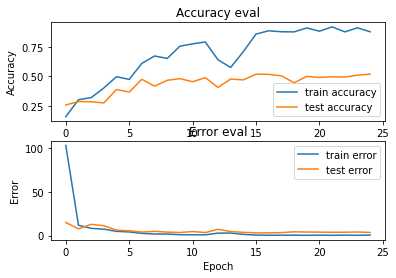

In [12]:
plot_history(history)

In [13]:
test_error, test_accuracy = model.evaluate(inputs_test, targets_test, verbose=1)
print("Accuracy on test set is: {}".format(test_accuracy))

# x = inputs_test[42:52]
# emo = targets_test[42:52]
#
# print(model.predict_classes(x))
# print(emo)


576/576 [==============================] - 0s 49us/sample - loss: 3.5399 - accuracy: 0.5191
Accuracy on test set is: 0.5190972089767456
